# Graph 

In [1]:
from __future__ import print_function
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; } </style>"))
import matplotlib.pyplot as plt

In [2]:
from pkg.realsense import *
from pkg.kinect import *
from pkg.marker_config import *
from pkg.stereo import *

pipeline=init_rs()
init_kn()
aruco_map, dictionary = get_aruco_config()

Start streaming
Device configuration: 
	color_format: 3 
	(0:JPG, 1:NV12, 2:YUY2, 3:BGRA32)

	color_resolution: 5 
	(0:OFF, 1:720p, 2:1080p, 3:1440p, 4:1536p, 5:2160p, 6:3072p)

	depth_mode: 3 
	(0:OFF, 1:NFOV_2X2BINNED, 2:NFOV_UNBINNED,3:WFOV_2X2BINNED, 4:WFOV_UNBINNED, 5:Passive IR)

	camera_fps: 2 
	(0:5 FPS, 1:15 FPS, 2:30 FPS)

	synchronized_images_only: False 
	(True of False). Drop images if the color and depth are not synchronized

	depth_delay_off_color_usec: 0 ms. 
	Delay between the color image and the depth image

	wired_sync_mode: 0
	(0:Standalone mode, 1:Master mode, 2:Subordinate mode)

	subordinate_delay_off_master_usec: 0 ms.
	The external synchronization timing.

	disable_streaming_indicator: False 
	(True or False). Streaming indicator automatically turns on when the color or depth camera's are in use.




In [28]:
T_c21, kn_config, rs_config = calibrate_stereo(aruco_map, dictionary)
cameraMatrix, distCoeffs  = kn_config

In [29]:
from pkg.calibrator import *
TEST_CALIB = False

if TEST_CALIB:
    try: T_bbbr_load_panda, T_rooo_load_panda, Teo_ref_load_panda = load_offset("panda")
    except: T_bbbr_load_panda, T_rooo_load_panda, Teo_ref_load_panda = [np.identity(4)]*3
    try: T_bbbr_load_indy, T_rooo_load_indy, Teo_ref_load_indy = load_offset("indy")
    except: T_bbbr_load_indy, T_rooo_load_indy, Teo_ref_load_indy = [np.identity(4)]*3
else:
    T_bbbr_load_panda, T_rooo_load_panda, Teo_ref_load_panda = [np.identity(4)]*3
    T_bbbr_load_indy, T_rooo_load_indy, Teo_ref_load_indy = [np.identity(4)]*3
T_reeo_load_panda = np.matmul(np.matmul(Teo_ref_load_panda, T_rooo_load_panda),SE3_inv(Teo_ref_load_panda))
T_reeo_load_indy = np.matmul(np.matmul(Teo_ref_load_indy, T_rooo_load_indy),SE3_inv(Teo_ref_load_indy))

In [30]:
while True:
    try:
        objectPose_dict, corner_dict, color_image, rs_image, rs_corner_dict, objectPoints_dict, point3D_dict, err_dict = \
            get_object_pose_dict_stereo(T_c21, kn_config, rs_config, aruco_map, dictionary)
#         color_image, depth_image = get_kinect_image_depth()
#         objectPose_dict, corner_dict = get_object_pose_dict_stereo(aruco_map, dictionary, cameraMatrix, distCoeffs)
#         refine_by_depth(depth_image, objectPose_dict, corner_dict, aruco_map, cameraMatrix, distCoeffs)
        Tbi = get_T_rel('floor', 'indy0', objectPose_dict)
        Tbi =  np.matmul(Tbi, T_bbbr_load_indy)
        xyz_indy0, rpy_indy0 = T2xyzrpy(Tbi)
        Tbp = get_T_rel('floor', 'panda1', objectPose_dict)
        Tbp = np.matmul(Tbp, T_bbbr_load_panda)
        xyz_panda1, rpy_panda1 = T2xyzrpy(Tbp)
        T_bc = SE3_inv(objectPose_dict['floor'])
        T_bo_0 = get_T_rel('floor', 'box1', objectPose_dict)
        xyz_cam, rvec_cam = T2xyzrvec(T_bc)
        xyz_box1, rvec_box1 = T2xyzrvec(T_bo_0)
        xyz_goal, rvec_goal = T2xyzrvec(get_T_rel('floor', 'goal', objectPose_dict))
        xyz_wall, rvec_wall = T2xyzrvec(get_T_rel('floor', 'wall', objectPose_dict))
        break
    except KeyError as e:
        print(e)
        break
#     except Exception as e:
#         print(e)
#         pass

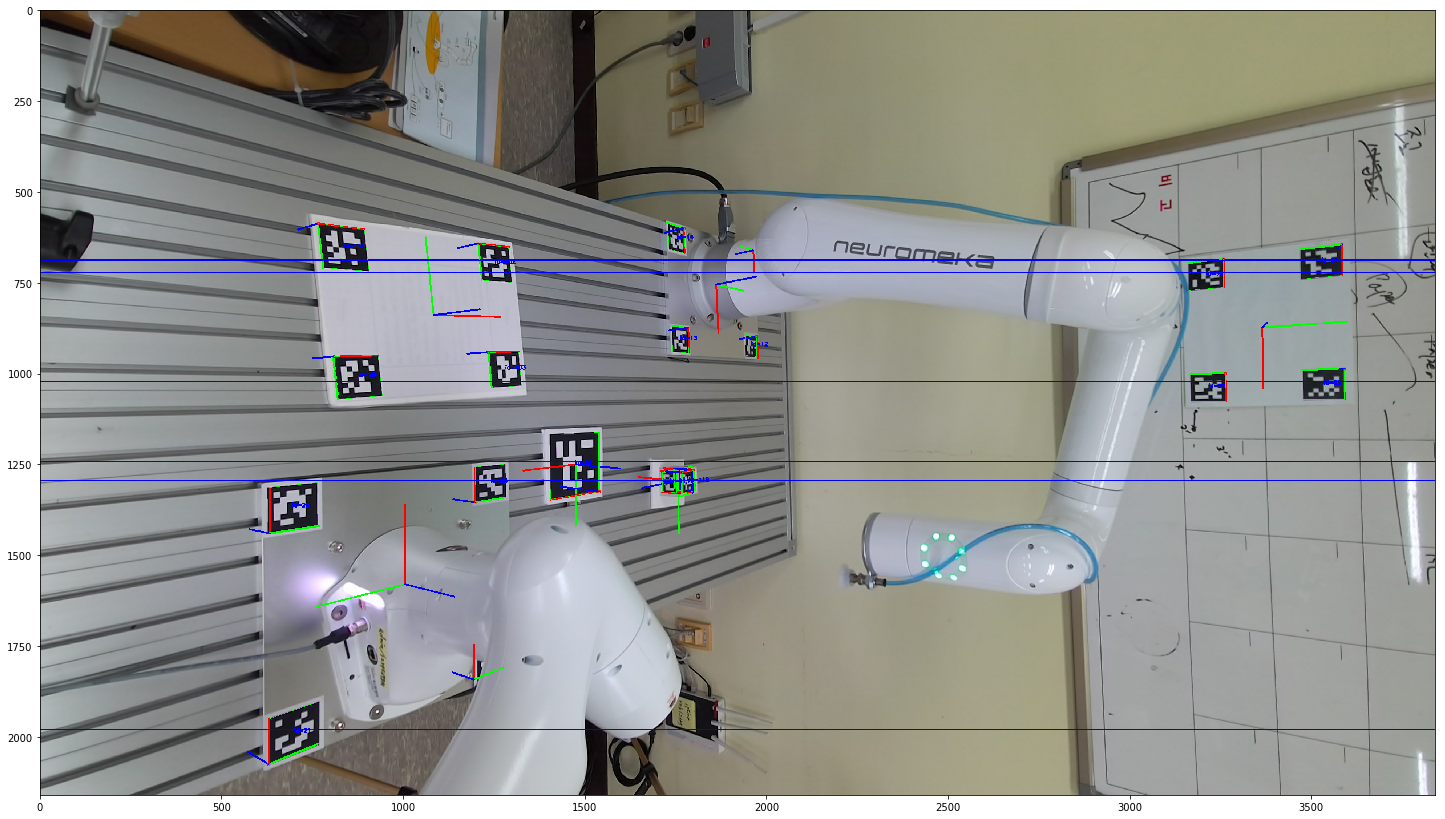

In [31]:
color_image_out = draw_objects(color_image, aruco_map, objectPose_dict, corner_dict, cameraMatrix, distCoeffs, axis_len=0.1)
plt.figure(figsize=(25,15))
plt.imshow(color_image_out[:,:,[2,1,0]])

In [32]:
# disconnect_kn()

In [33]:
# disconnect_rs()

In [34]:
urdf_content = None
from pkg.robots_custom import *
xcustom = XacroCustomizer()
xcustom.clear()
# xcustom.add_robot(RobotType.indy7_robot, xyz=[0,-0.5,0], rpy=[0,0,0])
# xcustom.add_robot(RobotType.panda_robot, xyz=[0,0.5,0], rpy=[0,0,0])
xcustom.add_robot(RobotType.indy7_robot, xyz=xyz_indy0, rpy=rpy_indy0)
xcustom.add_robot(RobotType.panda_robot, xyz=xyz_panda1, rpy=rpy_panda1)
xcustom.write_xacro()
vel_scale = 1.0/2.0
effort_scale = 1.0/2.0
JOINT_NAMES, LINK_NAMES, ZERO_JOINT_POSE, urdf_content = \
        xcustom.convert_xacro_to_urdf(
        joint_fix_dict={'finger':'upper'},
        joint_offset_dict={'panda1_hand_joint': T_reeo_load_panda, 'indy0_tcp': T_reeo_load_indy},
        vel_limit_dict={k: v*vel_scale for k,v in {
            'panda1_joint1': np.deg2rad(150),  'panda1_joint2': np.deg2rad(150), 
            'panda1_joint3': np.deg2rad(150), 'panda1_joint4': np.deg2rad(150), 
            'panda1_joint5': np.deg2rad(180), 'panda1_joint6': np.deg2rad(180), 'panda1_joint7': np.deg2rad(180), 
            'indy0_joint0': np.deg2rad(150), 'indy0_joint1': np.deg2rad(150), 'indy0_joint2': np.deg2rad(150), 
            'indy0_joint3': np.deg2rad(180), 'indy0_joint4': np.deg2rad(180), 'indy0_joint5': np.deg2rad(180), 
        }.items()},
        effort_limit_dict={k: v*effort_scale for k,v in {
            'panda1_joint1': np.deg2rad(360),  'panda1_joint2': np.deg2rad(360), 
            'panda1_joint3': np.deg2rad(360), 'panda1_joint4': np.deg2rad(360), 
            'panda1_joint5': np.deg2rad(360), 'panda1_joint6': np.deg2rad(360), 'panda1_joint7': np.deg2rad(360), 
            'indy0_joint0': np.deg2rad(360), 'indy0_joint1': np.deg2rad(360), 'indy0_joint2': np.deg2rad(360), 
            'indy0_joint3': np.deg2rad(360), 'indy0_joint4': np.deg2rad(360), 'indy0_joint5': np.deg2rad(360), 
        }.items()}
    )
ZERO_JOINT_POSE=np.array([0,0,-np.pi/2,0,-np.pi/2,0,
                          0,-np.pi/8,0,-np.pi/2,0,np.pi/2,0])
refine_meshes()
xcustom.start_rviz()
    
from pkg.constraint_graph import *
from pkg.constants import *
import matplotlib.pyplot as plt
from pkg.plot_utils import *
from pkg.utils import *
# from threading import Thread, Lock
from multiprocessing import Process, Lock, Manager
PROC_MODE = True
rospy.init_node('task_planner', anonymous=True)

Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran0']/actuator[@name='indy0_motor0']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran1']/actuator[@name='indy0_motor1']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran2']/actuator[@name='indy0_motor2']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran3']/actuator[@name='indy0_motor3']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran4']/actuator[@name='indy0_motor4']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran5']/actuator[@name='indy0_motor5']


In [35]:
gtimer = GlobalTimer.instance()
gtimer.reset()
graph = ConstraintGraph(urdf_path=URDF_PATH, joint_names=JOINT_NAMES, link_names=LINK_NAMES, urdf_content=urdf_content,
                       connect_panda = True, connect_indy = True)
col_items_dict = graph.set_fixed_geometry_items(
    get_geometry_items_dict(graph.urdf_content, color=(0,1,0,0.5), display=True, collision=True, 
                             exclude_link=["panda1_link7"]))

Connect: Server IP (192.168.0.63)


# Custom Robots

In [9]:
gtimer.tic("set_scene")
collision=True
graph.add_geometry_items("world", 
                         [
                           GeoMesh(uri="package://my_mesh/meshes/stl/end_tool_asm_ctd.stl", BLH=(0.01,0.01,0.01), orientation_mat=Rot_axis(3,np.pi/16), scale=(1e-3,1e-3,1e-3), name="gripper1", link_name="indy0_tcp", 
                                   urdf_content=graph.urdf_content, color=(0.1,0.1,0.1,1), collision=False),
                           GeoBox(np.dot(Rot_axis(3,np.pi*2/16), (-0.055, 0,0.012)), (0.05,0.05,0.07), orientation=(0,0,np.pi*2/16), 
                                  name="gripper1_col", link_name="indy0_tcp", urdf_content=graph.urdf_content, color=(0,1,0,0.5), collision=collision),
                           GeoBox((0,0,-0.005), (3,3,0.01), name="floor", link_name="world", urdf_content=graph.urdf_content, color=(0.6,0.6,0.6,1), collision=collision),
                           GeoBox(xyz_wall, (3,3,0.05),orientation=rvec_wall, name="wall", link_name="world", urdf_content=graph.urdf_content, color=(0.6,0.6,0.6,1), collision=collision),
                           GeoBox(np.subtract(xyz_cam, [0,0,xyz_cam[2]/2]), 
                                  (0.1,0.1,xyz_cam[2]), 
                                  name="cam_pole", link_name="world", urdf_content=graph.urdf_content, color=(0.6,0.6,0.6,1), collision=collision),
#                            GeoBox((0.4,0.4,0.15), (0.15,0.15,0.3), name="stepper", link_name="world", urdf_content=graph.urdf_content, color=(0.4,0.3,0.0,1), collision=collision),
                           GeoBox(xyz_goal, (0.1,0.1,1e-3),orientation=rvec_goal, name="goal_disp", link_name="world", urdf_content=graph.urdf_content, color=(0.8,0.0,0.0,1), collision=False)],
                         fixed=True)

graph.add_geometry_items("world", 
                         [GeoBox(xyz_box1, (0.05,0.05,0.05),orientation=rvec_box1, name="box1", link_name="world", urdf_content=graph.urdf_content, color=(0.3,0.3,0.8,1), collision=collision)],
                         fixed=False)

graph.register_binder(name='grip1', _type=VacuumTool, point=[0,-2.5e-2,11e-2], link_name="panda1_hand", direction=[0,1,0])
graph.register_binder(name='vac2', _type=VacuumTool, point=[-0.055,0,0.048], link_name="indy0_tcp", direction=[0,0,1])
graph.register_binder(name='floor', _type=PlacePlane, direction=[0,0,1])
graph.register_binder(name='goal', _type=PlaceFrame, point=xyz_goal, orientation=rvec_goal, link_name="world")

box1_put_point = get_put_dir(Robj=Rotation.from_rotvec(rvec_box1).as_dcm(), dir_vec_dict=dir_vec_dict)+"_p"
graph.register_object('box1', _type=BoxAction, binding=(box1_put_point,"floor"), hexahedral=True)

graph.build_graph()
gtimer.toc("set_scene")
print("put_point: {}".format(box1_put_point))

put_point: back_p


# Set RVIZ

In [10]:
gtimer.tic("set_sim")
graph.set_simulation(nWSR=300, regularization_factor= 1e-6)
gtimer.toc("set_sim")
# graph.show_pose(ZERO_JOINT_POSE, execute=True)

Please create a subscriber to the marker
publication OK
published: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Please create a subscriber to the marker


In [11]:
if graph.connect_indy and graph.connect_panda:
    graph.show_pose(graph.get_real_robot_pose())
else:
    graph.show_pose(ZERO_JOINT_POSE)

# Calibration - indy

## Sample configurations

In [12]:
graph.set_camera_config(aruco_map, dictionary, cameraMatrix, distCoeffs, corner_dict)

In [13]:
if TEST_CALIB:
    Teo_ref = Teo_ref_load_indy
else:
    ref_ori = (-2, 1, -1)
#     Offset_eo = SE3(np.identity(3), np.multiply(-1e-3, [-8.62282816e-01 -5.06427026e-01 -1.09526722e-04]))
#     Teo_ref = np.matmul(Offset_eo, SE3(Rot_zyx(*np.multiply(np.pi/2, ref_ori)), [0,0,0.026]))
    Teo_ref = SE3(Rot_zyx(*np.multiply(np.pi/2, ref_ori)), [0,0,0.026])

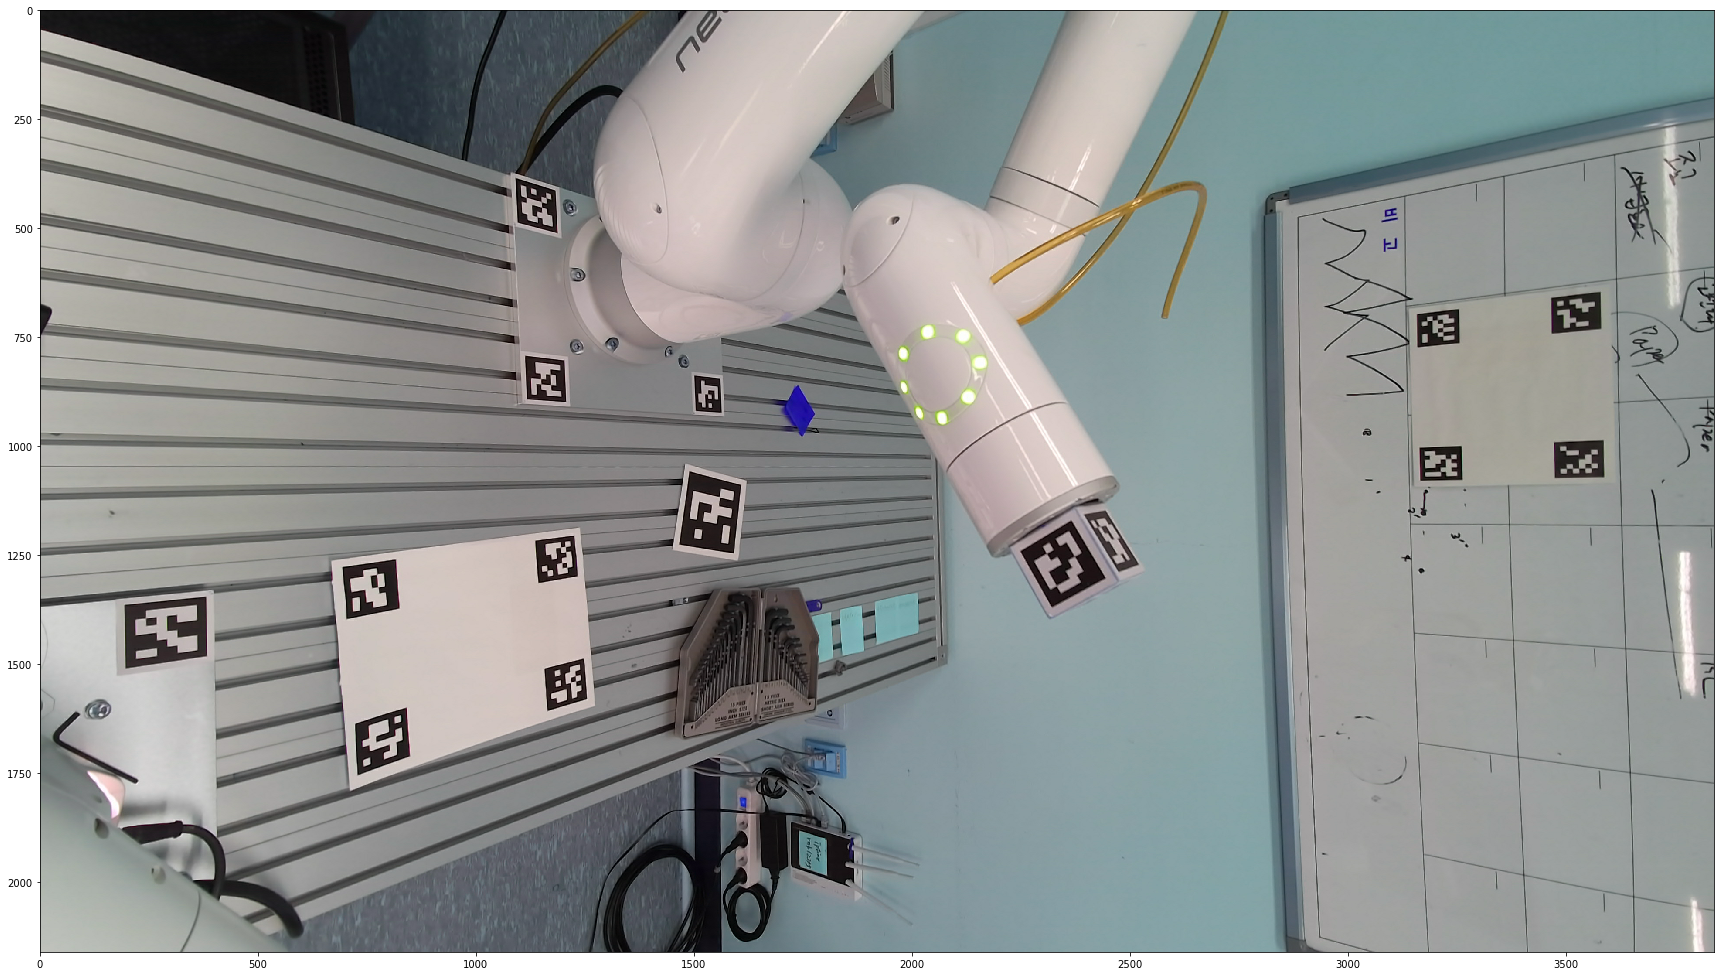

In [14]:
color_image = get_kinect_image()
plt.figure(figsize=(30,20))
plt.imshow(color_image)

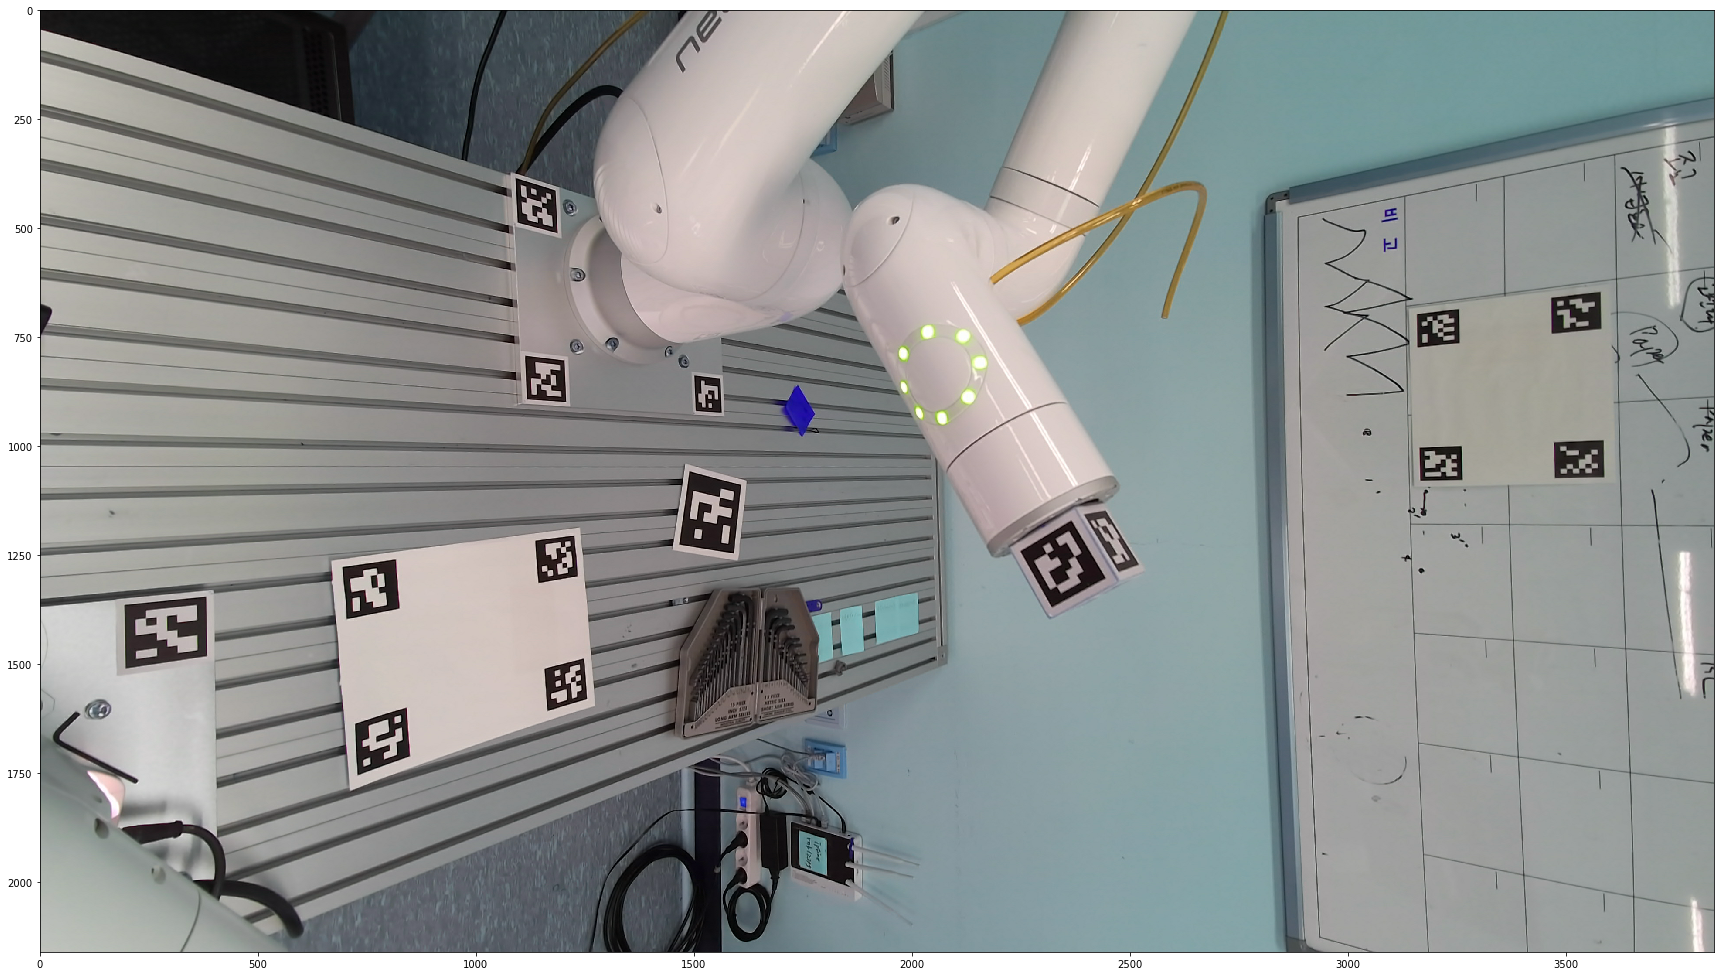

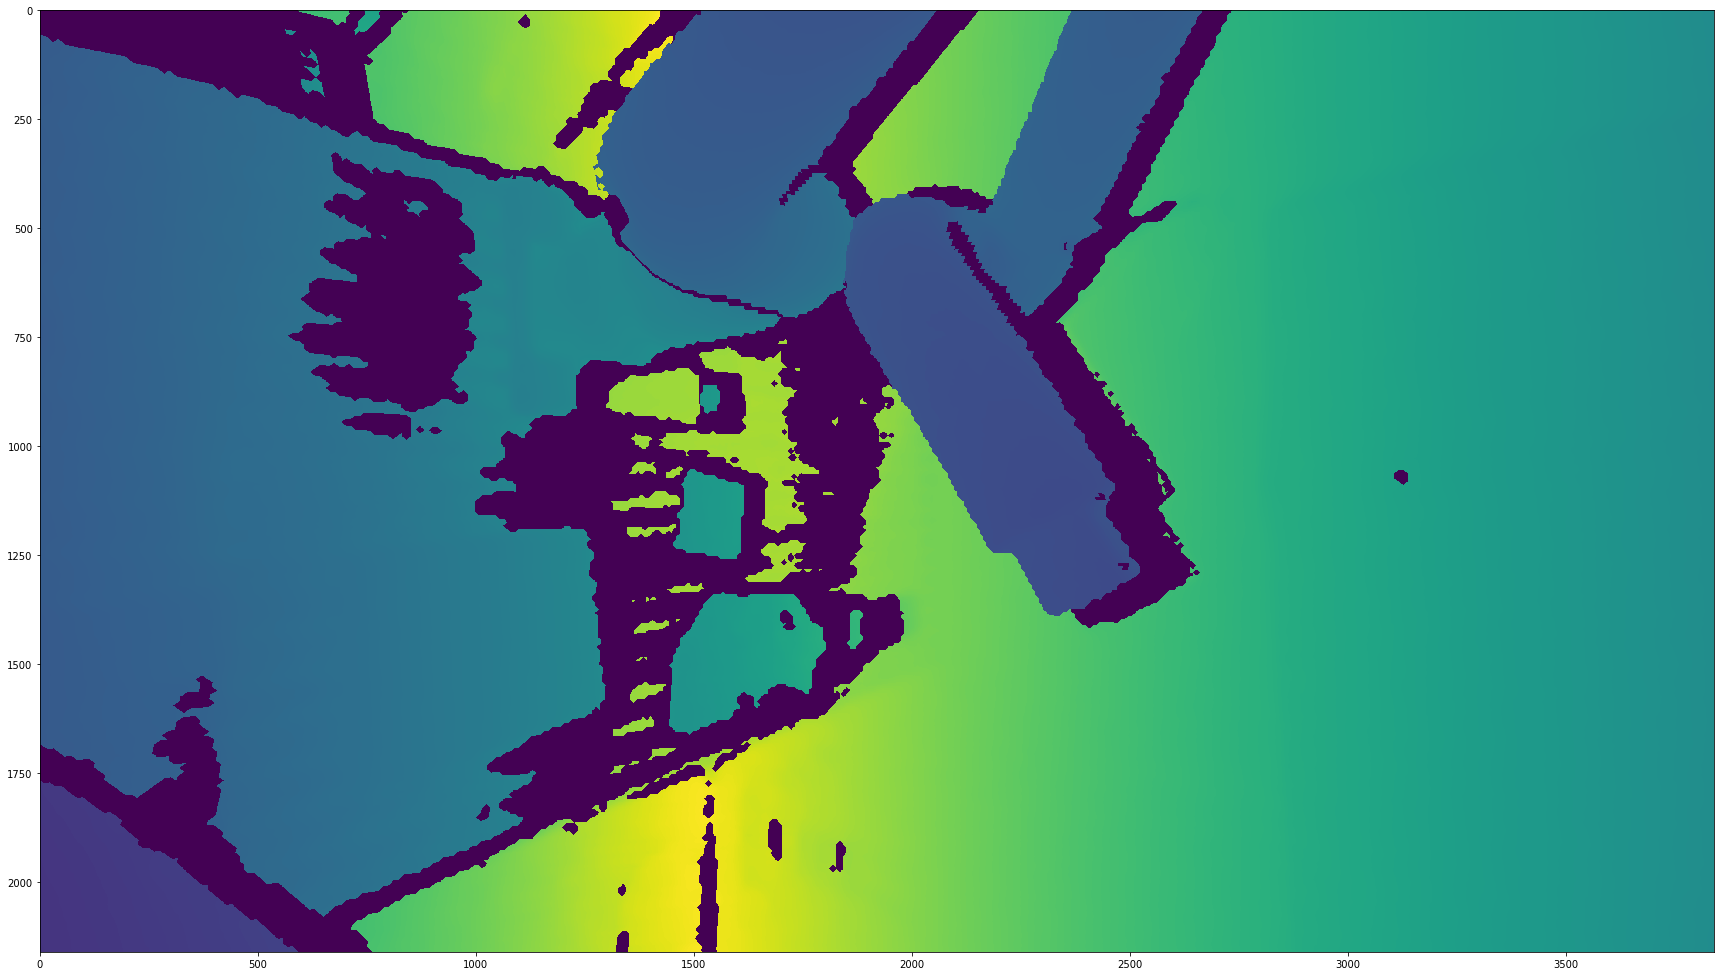

In [15]:
color_image, depth_image = get_kinect_image_depth()
plt.figure(figsize=(30,20))
plt.imshow(color_image)
plt.figure(figsize=(30,20))
plt.imshow(depth_image)

In [26]:
self =graph
color_image, depth_image = get_kinect_image_depth()
objectPose_dict, corner_dict = get_object_pose_dict(color_image, self.aruco_map, self.dictionary,
                                                    self.cameraMatrix, self.distCoeffs)

In [27]:
objectPose_dict

{'box1': array([[-0.43888578, -0.69068384, -0.57474786,  0.12575786],
        [-0.85724884,  0.5135363 ,  0.03748272,  0.04357564],
        [ 0.26926515,  0.50915253, -0.8174717 ,  0.50027287],
        [ 0.        ,  0.        ,  0.        ,  1.        ]],
       dtype=float32),
 'floor': array([[-0.5632216 ,  0.06238334,  0.82394767, -0.41550845],
        [ 0.06649411,  0.997334  , -0.03005786,  0.158588  ],
        [-0.82362616,  0.03785843, -0.56586814,  0.8563198 ],
        [ 0.        ,  0.        ,  0.        ,  1.        ]],
       dtype=float32),
 'goal': array([[ 0.08261044, -0.5738425 ,  0.8147885 , -0.22756472],
        [-0.9837133 , -0.17791685, -0.02556647,  0.03338321],
        [ 0.15963574, -0.7994063 , -0.5791943 ,  1.1176676 ],
        [ 0.        ,  0.        ,  0.        ,  1.        ]],
       dtype=float32),
 'indy0': array([[ 0.03481603,  0.57469505,  0.8176267 , -0.30532712],
        [ 0.9993088 , -0.03068361, -0.02098543, -0.24880555],
        [ 0.01302751,  0.8

In [31]:
refine_by_depth(depth_image, objectPose_dict, corner_dict, aruco_map, cameraMatrix, distCoeffs)

In [32]:
objectPose_dict

{'box1': array([[-0.43888578, -0.69068384, -0.57474786,  0.12939152],
        [-0.85724884,  0.5135363 ,  0.03748272,  0.04483472],
        [ 0.26926515,  0.50915253, -0.8174717 ,  0.51472783],
        [ 0.        ,  0.        ,  0.        ,  1.        ]],
       dtype=float32),
 'floor': array([[-0.5632216 ,  0.06238334,  0.82394767, -0.42817876],
        [ 0.06649411,  0.997334  , -0.03005786,  0.1634239 ],
        [-0.82362616,  0.03785843, -0.56586814,  0.8824319 ],
        [ 0.        ,  0.        ,  0.        ,  1.        ]],
       dtype=float32),
 'goal': array([[ 0.08261044, -0.5738425 ,  0.8147885 , -0.23212633],
        [-0.9837133 , -0.17791685, -0.02556647,  0.03405239],
        [ 0.15963574, -0.7994063 , -0.5791943 ,  1.1400715 ],
        [ 0.        ,  0.        ,  0.        ,  1.        ]],
       dtype=float32),
 'indy0': array([[ 0.03481603,  0.57469505,  0.8176267 , -0.35282218],
        [ 0.9993088 , -0.03068361, -0.02098543, -0.28750843],
        [ 0.01302751,  0.8

In [220]:

objectPose_dict = {}
objectrtvec_dict = {}
for obj_name, marker_list in aruco_map.items():
    objectPoints = np.zeros((0,3))
    imagePoints = np.zeros((0,2))
    pt3dPoints = np.zeros((0,3))
    for marker in marker_list:
        if marker.idx in corner_dict:
            objectPoints = np.concatenate([objectPoints, marker.corners], axis=0)
            imagePoints = np.concatenate([imagePoints, corner_dict[marker.idx]], axis=0)
            pt3dPoints = np.concatenate([pt3dPoints, pt3d_dict[marker.idx]], axis=0)
    if len(objectPoints) == 0:
        continue
    ret, rvec, tvec = cv2.solvePnP(objectPoints, imagePoints, cameraMatrix, distCoeffs)
    R, jac = cv2.Rodrigues(rvec)
    Tobj = SE3(R, tvec.flatten())
    
    idx_zs = np.where(pt3dPoints[:,2]>0.01)[0]
    if len(idx_zs)>0:
        O3 = objectPoints[idx_zs].transpose()
        O_pad = np.pad(O3, [[0,1],[0,0]], 'constant', constant_values=1)
        O_pad.astype(np.float16)
        P3_pnp = np.matmul(Tobj, O_pad)[:3]
        P3 = pt3dPoints[idx_zs].transpose()
        zscale = np.mean(P3[2,:]/P3_pnp[2,:])
        Tobj[:3,3] *= zscale
    
    objectPose_dict[obj_name] = Tobj

In [197]:

P_pad = np.pad(P3, [[0,1],[0,0]], 'constant', constant_values=1)
P_pad.astype(np.float16)

array([[-0.592  , -0.598  , -0.575  , -0.5674 ],
       [ 0.1404 ,  0.09143,  0.0917 ,  0.1411 ],
       [ 0.66   ,  0.666  ,  0.715  ,  0.706  ],
       [ 1.     ,  1.     ,  1.     ,  1.     ]], dtype=float16)

In [201]:
P3

array([[-0.59158429, -0.59812899, -0.57542501, -0.56761058],
       [ 0.14038462,  0.09140558,  0.09168364,  0.1410998 ],
       [ 0.66      ,  0.666     ,  0.715     ,  0.706     ]])

In [181]:
O3 = objectPoints.transpose()
O_pad = np.pad(O3, [[0,1],[0,0]], 'constant', constant_values=1)
O_pad.astype(np.float16)

array([[ 0.0892,  0.1372,  0.1372,  0.0892],
       [-0.0972, -0.0972, -0.1451, -0.1451],
       [ 0.    ,  0.    ,  0.    ,  0.    ],
       [ 1.    ,  1.    ,  1.    ,  1.    ]], dtype=float16)

In [187]:
O_45 = np.matmul(SE3(Rot_axis(1, np.pi/4), [0]*3), O_pad)

In [188]:
Tinv = np.matmul(O_45, np.linalg.inv(P_pad))

In [189]:
Tinv.astype(np.float16)

array([[ 0.1729 , -1.013  , -0.07434,  0.3826 ],
       [-0.7925 ,  0.066  , -0.326  , -0.3318 ],
       [-0.7925 ,  0.066  , -0.326  , -0.3318 ],
       [ 0.     ,  0.     ,  0.     ,  1.     ]], dtype=float16)

array([[ 0.0892, -0.0972,  0.001 ,  1.    ],
       [ 0.1372, -0.0972,  0.001 ,  1.    ],
       [ 0.1372, -0.1451,  0.001 ,  1.    ],
       [ 0.0892, -0.1451,  0.001 ,  1.    ]], dtype=float16)

In [143]:
T_inv_t = np.matmul(np.linalg.inv(np.pad(pt3dPoints, [[0,0],[0,1]], 'constant', constant_values=1)),
                    np.pad(objectPoints, [[0,0],[0,1]], 'constant', constant_values=1))

In [144]:
T_inv = T_inv_t.transpose()

In [145]:
T_inv.astype(np.float16)

array([[-2.353e-04, -9.294e-04,  1.339e-04, -7.744e-03],
       [-4.163e-04, -5.358e-05, -8.159e-04,  2.020e-01],
       [-0.000e+00,  0.000e+00,  0.000e+00,  1.000e-03],
       [-0.000e+00,  0.000e+00,  0.000e+00,  1.000e+00]], dtype=float16)

In [125]:
np.pad(pt3dPoints, [[0,0],[0,1]], 'constant', constant_values=1).shape

(4, 4)

In [117]:
T = np.matmul(np.linalg.pinv(np.pad(objectPoints, [[0,0],[0,1]], 'constant', constant_values=1)), 
                         np.pad(pt3dPoints, [[0,0],[0,1]], 'constant', constant_values=1)).transpose().astype(np.float16)

In [122]:
np.pad(objectPoints, [[0,0],[0,1]], 'constant', constant_values=1).transpose().astype(np.float16)

array([[ 0.0892,  0.1372,  0.1372,  0.0892],
       [-0.0972, -0.0972, -0.1451, -0.1451],
       [-0.    , -0.    ,  0.    ,  0.    ],
       [ 1.    ,  1.    ,  1.    ,  1.    ]], dtype=float16)

In [119]:
np.matmul(T, np.pad(objectPoints, [[0,0],[0,1]], 'constant', constant_values=1).transpose())

array([[-591.13609882, -597.55609882, -573.46009882, -567.04009882],
       [ 140.33232358,   91.22832358,   91.82532358,  140.92932358],
       [ 659.26225284,  665.76025284,  712.27225284,  705.77425284],
       [   1.        ,    1.        ,    1.        ,    1.        ]])

In [120]:
pt3dPoints.astype(np.float16)

array([[-590.5,  140.1,  659. ],
       [-598. ,   91.4,  666. ],
       [-573. ,   91.7,  712. ],
       [-567.5,  141.1,  706. ]], dtype=float16)

In [104]:
objectPoints\pt3dPoints = T.transpose()

NameError: name 'T' is not defined

In [105]:
pt3dPoints.shape

(4, 3)

In [98]:
marker.idx

24

In [95]:
obj_name

'panda1'

In [96]:
imagePoints

array([[ 196., 1509.],
       [ 194., 1364.],
       [ 381., 1346.],
       [ 381., 1482.]])

In [94]:
objectPoints

array([[ 8.92000014e-02, -9.72000027e-02, -2.93915245e-18],
       [ 1.37200001e-01, -9.72000027e-02, -2.93915245e-18],
       [ 1.37200001e-01, -1.45200003e-01,  2.93915245e-18],
       [ 8.92000014e-02, -1.45200003e-01,  2.93915245e-18]])

In [89]:
pt3d_dict

{12: array([[  -0.        ,   -0.        ,    0.        ],
        [  -0.        ,   -0.        ,    0.        ],
        [-405.90453664, -177.39331349, 1816.        ],
        [-408.23291785, -256.89323741, 1815.        ]]),
 13: array([[-376.0925689 , -156.11535209,  980.        ],
        [-369.76348742, -104.82912304,  968.        ],
        [-396.16841852, -102.7007924 ,  923.        ],
        [-401.65719071, -153.11088564,  932.        ]]),
 14: array([[-380.10127617, -355.21830434,  970.        ],
        [-376.31486473, -303.93111922,  965.        ],
        [-404.6636268 , -302.46050459,  925.        ],
        [-405.49031775, -351.03862881,  922.        ]]),
 23: array([[-590.68795481,  140.17191906,  659.        ],
        [-598.12898871,   91.40557766,  666.        ],
        [-573.00713329,   91.67172146,  712.        ],
        [-567.61058374,  141.09980359,  706.        ]]),
 91: array([[ 968.26597034, -264.01884589, 1112.        ],
        [ 970.38052323, -215.60523307

In [69]:
depth_values.shape

(60,)

In [73]:
np.matmul(np.linalg.inv(self.cameraMatrix), np.pad(points_sorted_undist, [[0,0],[0,1]], 'constant', constant_values=1).transpose())

array([[-0.19320077, -0.19175875, -0.22351571, -0.22492172, -0.383772  ,
        -0.38198707, -0.42921822, -0.43095838, -0.39185699, -0.38996359,
        -0.43799681, -0.43979427, -0.89633984, -0.89809157, -0.8047853 ,
        -0.803981  ,  0.87074278,  0.87107767,  0.81442964,  0.81454852,
         0.87461002,  0.87509301,  0.81903952,  0.81804445,  0.71112839,
         0.71163246,  0.6627795 ,  0.66227009,  0.70715454,  0.70802486,
         0.65866062,  0.65831426, -0.35383091, -0.4019872 , -0.40531863,
        -0.35815232, -0.5646562 , -0.62521186, -0.62938844, -0.56924152,
        -0.58054292, -0.64134278, -0.64546059, -0.58410809, -0.36701523,
        -0.41478467, -0.41878113, -0.3715177 ,  0.21974527,  0.18130791,
         0.24442292,  0.28583612,  0.30240156,  0.25998742,  0.28619382,
         0.3263726 , -0.24390891, -0.23173433, -0.16758217, -0.17606709],
       [-0.13791856, -0.09562754, -0.09768354, -0.14153897, -0.15876506,
        -0.10829455, -0.11126846, -0.16481699, -0.

In [76]:
pt3d_sorted.shape

(3, 60)

In [81]:
pt3d_sorted.shape

(15, 4, 3)

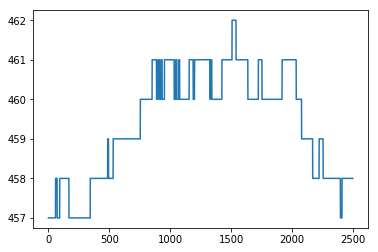

In [9]:
plt.plot(depth_image[1300,500:3000])

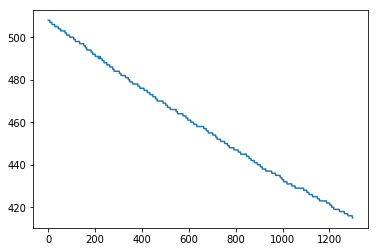

In [10]:
plt.plot(depth_image[700:2000,2000])

In [21]:
corner_dict

{12: array([[1560.,  844.],
        [1563.,  923.],
        [1504.,  919.],
        [1501.,  838.]], dtype=float32), 13: array([[1203.,  803.],
        [1207.,  898.],
        [1116.,  892.],
        [1112.,  793.]], dtype=float32), 14: array([[1182.,  414.],
        [1187.,  511.],
        [1097.,  488.],
        [1090.,  385.]], dtype=float32), 23: array([[ 196., 1509.],
        [ 194., 1364.],
        [ 381., 1346.],
        [ 381., 1482.]], dtype=float32), 91: array([[3580.,  647.],
        [3580.,  731.],
        [3468.,  742.],
        [3468.,  659.]], dtype=float32), 92: array([[3586.,  987.],
        [3586., 1071.],
        [3475., 1073.],
        [3474.,  990.]], dtype=float32), 93: array([[3261., 1000.],
        [3262., 1077.],
        [3166., 1078.],
        [3165., 1003.]], dtype=float32), 94: array([[3255.,  686.],
        [3255.,  764.],
        [3159.,  772.],
        [3158.,  697.]], dtype=float32), 101: array([[1256., 1580.],
        [1164., 1606.],
        [1157., 151

In [32]:
# init
sample_list = []
image_list = []
pose_list = []
j_ref = graph.indy.get_joint_pos()
test_jdx = 5 - 1
test_step = -10
test_num = 9

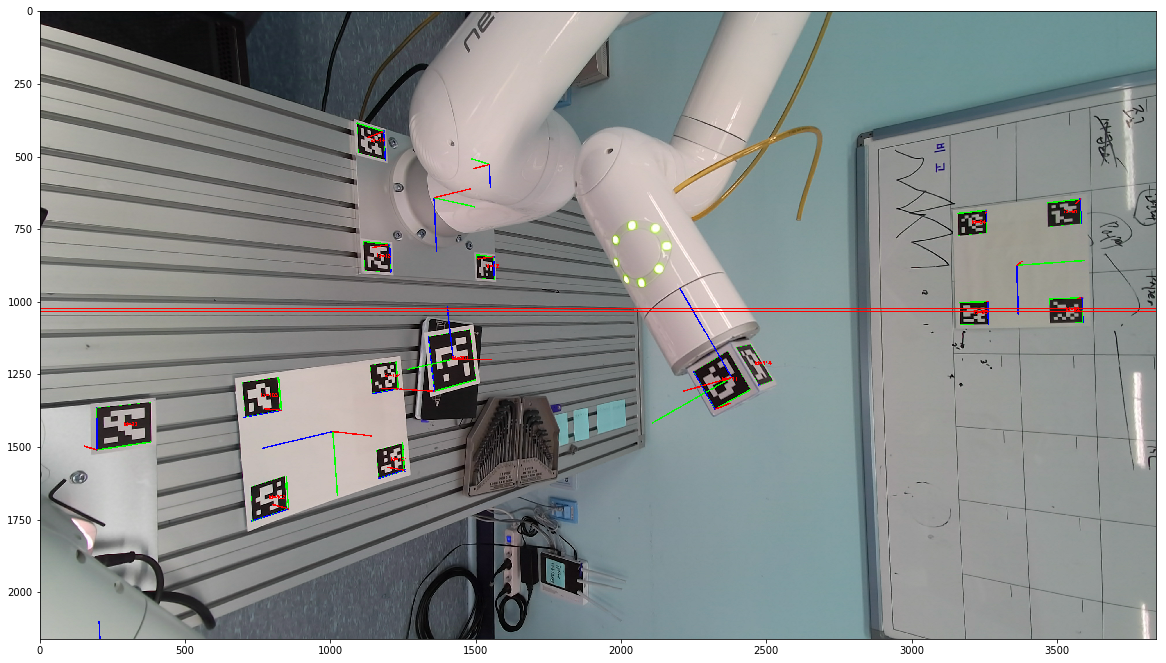

In [53]:
xyz_cam, rvec_cam, xyz_cal, rvec_cal, color_image, objectPose_dict, corner_dict = graph.sample_Trel('box1', 'indy0_tcp', 'indy0_link0', 'indy0', Teo=Teo_ref)
color_image_out = graph.draw_objects_graph(color_image, objectPose_dict, corner_dict)
pose_cur = graph.get_real_robot_pose()
plt.figure(figsize=(20,18))
plt.imshow(color_image_out)

In [54]:
xyz_cam[0][1]

-0.17130483388900758

In [30]:
for _ in range(test_num):
    # step
    j_ref[test_jdx] += test_step
    graph.indy.joint_move_to(j_ref)
    time.sleep(0.01)
    while not graph.indy.get_robot_status()['movedone']:
        time.sleep(0.01)
    time.sleep(0.5)

    # sample
    xyz_cam, rvec_cam, xyz_cal, rvec_cal, color_image, objectPose_dict = graph.sample_Trel('box1', 'indy0_tcp', 'indy0_link0', 'indy0', Teo=Teo_ref)
    color_image_out = graph.draw_objects_graph(color_image, objectPose_dict)
    pose_cur = graph.get_real_robot_pose()
#     plt.figure(figsize=(20,18))
#     plt.imshow(color_image_out)

    # stack
    sample_list.append((xyz_cam, rvec_cam, xyz_cal, rvec_cal, color_image, objectPose_dict))
    image_list.append(color_image_out.copy())
    pose_list.append(pose_cur)
    len(sample_list)

In [31]:
xyz_cal_list = np.array([sample[2][0]for sample in sample_list])
xyz_cam_list = np.array([sample[0][0]for sample in sample_list])
pose_list_arr = np.array(pose_list)[:, graph.indy_idx]

Text(0.5,1,'Z')

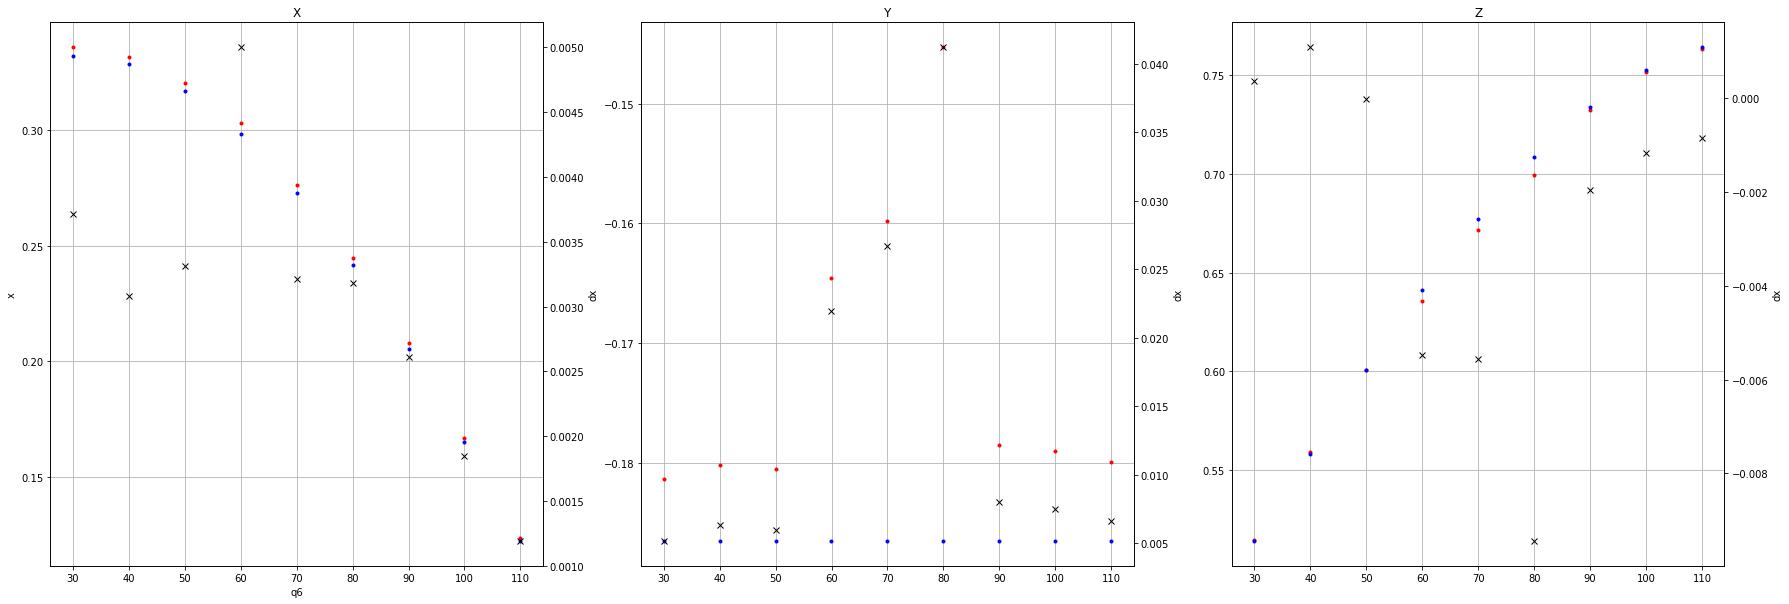

In [32]:
plt.figure(figsize=(30,10))
X = np.rad2deg(pose_list_arr[:,test_jdx])

ax1 = plt.subplot(1,3,1)
ax1.set_ylabel('x')
ax1.set_xlabel('q6')
ax1.plot(X, xyz_cam_list[:,0], '.r')
ax1.plot(X, xyz_cal_list[:,0], '.b')
ax1.grid()
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('dx')
ax2.plot(X, xyz_cam_list[:,0]-xyz_cal_list[:,0], 'xk')
plt.title("X")
ax1 = plt.subplot(1,3,2)
ax1.plot(X, xyz_cam_list[:,1], '.r')
ax1.plot(X, xyz_cal_list[:,1], '.b')
ax1.grid()
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('dx')
ax2.plot(X, xyz_cam_list[:,1]-xyz_cal_list[:,1], 'xk')
plt.title("Y")
ax1 = plt.subplot(1,3,3)
ax1.plot(X, xyz_cam_list[:,2], '.r')
ax1.plot(X, xyz_cal_list[:,2], '.b')
ax1.grid()
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('dx')
ax2.plot(X, xyz_cam_list[:,2]-xyz_cal_list[:,2], 'xk')
plt.title("Z")

In [161]:
xyz_cam, rvec_cam, xyz_cal, rvec_cal, color_image, objectPose_dict = graph.sample_Trel('box1', 'indy0_tcp', 'indy0_link0', 'indy0', Teo=Teo_ref)

In [172]:
Rbo = Rotation.from_rotvec(rvec_cal[0]).as_dcm()

In [173]:
V_ox = np.matmul(Rbe.transpose(), [1,0,0])

In [174]:
np.matmul(Rbo, V_ox)

array([ 1.00000000e+00, -1.01779479e-17,  5.55111512e-17])

In [175]:
V_ox

array([ 1.09526722e-04, -8.62282816e-01,  5.06427026e-01])

In [178]:
V_ex = np.matmul(Teo_ref[:3,:3], V_ox)
print(V_ex)

[-8.62282816e-01 -5.06427026e-01 -1.09526722e-04]


## calibrate

In [32]:
from pkg.calibrator import *

In [33]:
from pkg import calibrator

In [34]:
calibrator.CALIB_TIMEOUT = 10

In [35]:
set_RP_calib(sample_list)
T_err((np.identity(3), (0,0,0), np.identity(3), (0,0,0)))

0.0009046243171912352

In [112]:
T_bbbr, T_rooo = calibrate_offset()

Compiling cost function...
Computing gradient of cost function...
 iter		   cost val	    grad. norm
    1	+1.1354000698078540e+01	5.76927393e+00
    2	+7.9193579862450942e+00	1.73711229e+00
    3	+7.0639500649390445e+00	1.66480123e+00
    4	+6.9783212490413344e+00	3.68465632e+00
    5	+6.6486995678370802e+00	3.40908509e+00
    6	+5.5490080430001942e+00	2.32904213e+00
    7	+5.4847265129594218e+00	3.48213967e+00
    8	+5.2365516537580152e+00	3.24004771e+00
    9	+4.3969916628515167e+00	2.25071909e+00
   10	+3.5837458955423167e+00	6.29117481e-01
   11	+3.5370029079649563e+00	9.54892925e-01
   12	+3.4196802710927146e+00	3.02135003e-01
   13	+3.3982658489357598e+00	3.25655039e-01
   14	+3.3783906704310338e+00	2.14943950e-01
   15	+3.3676210087956209e+00	3.64041152e-01
   16	+3.3480885393824606e+00	1.83660265e-01
   17	+3.3441365872118771e+00	4.52378615e-01
   18	+3.3306570671279396e+00	3.22375483e-01
   19	+3.3242705304289020e+00	3.76703631e-01
   20	+3.3069733572822186e+00	1.70663087e-01


In [114]:
# save_offset("indy", T_bbbr, T_rooo, Teo_ref)

In [117]:
T_bbbr, T_rooo, Teo_ref = load_offset("indy")

In [118]:
Xopt = (SE3_R(T_bbbr), SE3_P(T_bbbr), SE3_R(T_rooo), SE3_P(T_rooo))
T_err(Xopt)

0.0008840439822441461

# Calibration - panda

## Sample configurations

In [12]:
graph.set_camera_config(aruco_map, dictionary, cameraMatrix, distCoeffs, corner_dict)

In [13]:
if TEST_CALIB:
    Teo_ref = Teo_ref_load_panda
else:
    Teo_ref = SE3(Rot_zyx(-np.pi/2,np.pi/2,0), [0,0,0.091])

In [14]:
sample_list = []
image_list = []

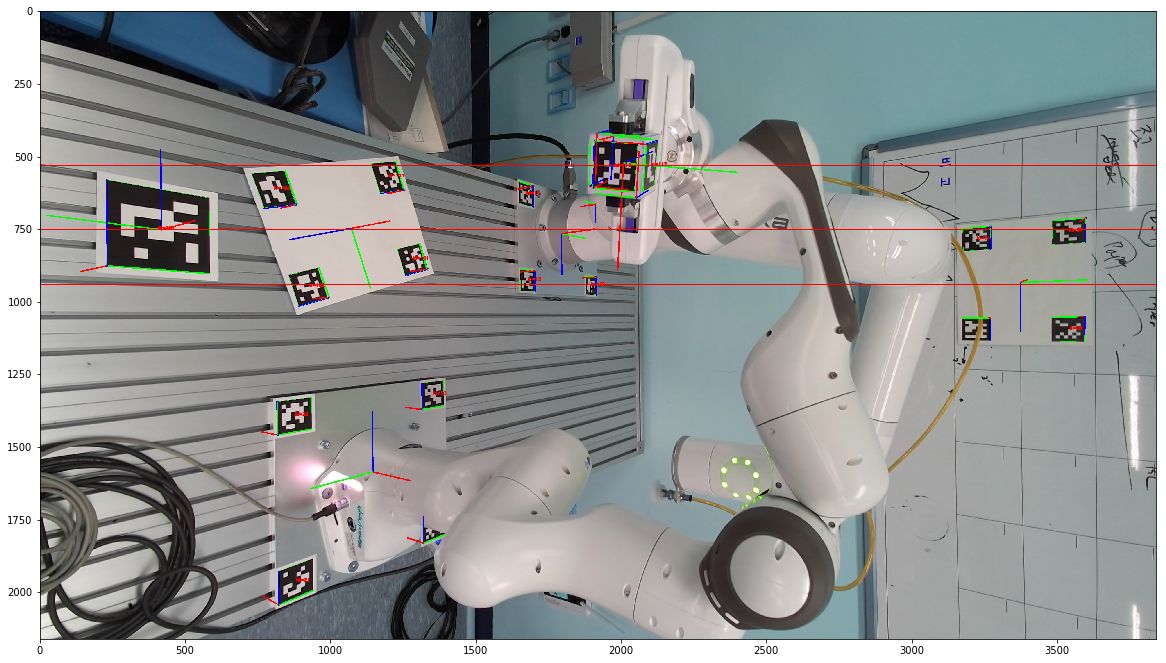

In [15]:
xyz_cam, rvec_cam, xyz_cal, rvec_cal, color_image, objectPose_dict = graph.sample_Trel('box1', 'panda1_hand', 'panda1_link0', 'panda1', Teo=Teo_ref)
color_image_out = graph.draw_objects_graph(color_image, objectPose_dict)
plt.figure(figsize=(20,18))
plt.imshow(color_image_out)

In [16]:
sample_list.append((xyz_cam, rvec_cam, xyz_cal, rvec_cal, color_image, objectPose_dict))
image_list.append(color_image_out.copy())

## calibrate

In [17]:
from pkg.calibrator import *

In [18]:
set_RP_calib(sample_list)
T_err((np.identity(3), (0,0,0), np.identity(3), (0,0,0)))

0.0019149846907554533

In [134]:
T_bbbr, T_rooo = calibrate_offset()

Compiling cost function...
Computing gradient of cost function...
 iter		   cost val	    grad. norm
    1	+1.1609282401648320e+01	7.95633528e+00
    2	+5.9714777907741068e+00	3.86462890e+00
    3	+5.4940300446667836e+00	5.96549950e+00
    4	+3.8392174174393801e+00	4.37826757e+00
    5	+2.6412741613466824e+00	3.19316227e+00
    6	+1.6829827932524795e+00	8.96547243e-01
    7	+1.5715671558219462e+00	6.28033975e-01
    8	+1.4935666799596194e+00	8.82520899e-01
    9	+1.4127304833090919e+00	8.60177414e-01
   10	+1.3474768882977493e+00	9.38858062e-01
   11	+1.2330751372355582e+00	5.58959874e-01
   12	+1.1673531757322217e+00	9.83534630e-01
   13	+1.0404051678928374e+00	5.00910759e-01
   14	+9.4118249181096048e-01	1.03132352e+00
   15	+8.2853846503201478e-01	8.04030115e-01
   16	+7.3519210417382563e-01	5.95595012e-01
   17	+6.6347706216425717e-01	7.23689986e-01
   18	+6.2476739777559875e-01	9.84173981e-01
   19	+5.1780199117077452e-01	4.55908212e-01
   20	+4.4762566450137220e-01	9.21803409e-01


In [33]:
# save_offset("panda", T_bbbr, T_rooo, Teo_ref)

In [35]:
T_bbbr, T_rooo, Teo_ref = load_offset("panda")

In [28]:
Xopt = (SE3_R(T_bbbr), SE3_P(T_bbbr), SE3_R(T_rooo), SE3_P(T_rooo))
T_err(Xopt)

0.0008191987154324842

In [62]:
graph.panda.move_finger(True)

True

In [19]:
graph.panda.move_finger(False)

False

# find_proper_offset - indy

In [19]:
val_dict  = {}
for i_x in range(-2,2):
    for i_y in range(-2,2):
        for i_z in range(-2,2):
            sample_list = []
#             image_list = []
            
            xyz_cam, rvec_cam, xyz_cal, rvec_cal, color_image, objectPose_dict = graph.sample_Trel('box1', 'indy0_tcp', 'indy0_link0', 'indy0', 
                                                                                             Teo= SE3(Rot_zyx(np.pi/2*i_x,np.pi/2*i_y,np.pi/2*i_z), [0,0,0.026]))
#             color_image_out = draw_objects_graph(self, color_image, objectPose_dict)
#             plt.figure(figsize=(20,18))
#             plt.imshow(color_image_out)

            sample_list.append((xyz_cam, rvec_cam, xyz_cal, rvec_cal, color_image, objectPose_dict))
#             image_list.append(color_image_out.copy())

            set_RP_calib(sample_list)
            print("done: {}".format((i_x, i_y,i_z)))
            val_dict[(i_x, i_y,i_z)] = T_err((np.identity(3), (0,0,0), np.identity(3), (0,0,0)))
print("min error case: {}".format(sorted(val_dict.items(), key=lambda x: x[1])[0]))

done: (-2, -2, -2)
done: (-2, -2, -1)
done: (-2, -2, 0)
done: (-2, -2, 1)
done: (-2, -1, -2)
done: (-2, -1, -1)
done: (-2, -1, 0)
done: (-2, -1, 1)
done: (-2, 0, -2)
done: (-2, 0, -1)
done: (-2, 0, 0)
done: (-2, 0, 1)
done: (-2, 1, -2)
done: (-2, 1, -1)
done: (-2, 1, 0)
done: (-2, 1, 1)
done: (-1, -2, -2)
done: (-1, -2, -1)
done: (-1, -2, 0)
done: (-1, -2, 1)
done: (-1, -1, -2)
done: (-1, -1, -1)
done: (-1, -1, 0)
done: (-1, -1, 1)
done: (-1, 0, -2)
done: (-1, 0, -1)
done: (-1, 0, 0)
done: (-1, 0, 1)
done: (-1, 1, -2)
done: (-1, 1, -1)
done: (-1, 1, 0)
done: (-1, 1, 1)
done: (0, -2, -2)
done: (0, -2, -1)
done: (0, -2, 0)
done: (0, -2, 1)
done: (0, -1, -2)
done: (0, -1, -1)
done: (0, -1, 0)
done: (0, -1, 1)
done: (0, 0, -2)
done: (0, 0, -1)
done: (0, 0, 0)
done: (0, 0, 1)
done: (0, 1, -2)
done: (0, 1, -1)
done: (0, 1, 0)
done: (0, 1, 1)
done: (1, -2, -2)
done: (1, -2, -1)
done: (1, -2, 0)
done: (1, -2, 1)
done: (1, -1, -2)
done: (1, -1, -1)
done: (1, -1, 0)
done: (1, -1, 1)
done: (1, 0,

# find_proper_offset - panda

In [ ]:
val_dict  = {}
for i_x in range(-2,2):
    for i_y in range(-2,2):
        for i_z in range(-2,2):
            sample_list = []
#             image_list = []
            
            xyz_cam, rvec_cam, xyz_cal, rvec_cal, color_image, objectPose_dict = graph.sample_Trel('box1', 'panda1_hand', 'panda1_link0', 'panda1', 
                                                                                             Teo=SE3(Rot_zyx(np.pi/2*i_x,np.pi/2*i_y,np.pi/2*i_z), [0,0,0.091]))
#             color_image_out = draw_objects_graph(self, color_image, objectPose_dict)
#             plt.figure(figsize=(20,18))
#             plt.imshow(color_image_out)

            sample_list.append((xyz_cam, rvec_cam, xyz_cal, rvec_cal, color_image, objectPose_dict))
#             image_list.append(color_image_out.copy())

            set_RP_calib(sample_list)
            print("done: {}".format((i_x, i_y,i_z)))
            val_dict[(i_x, i_y,i_z)] = T_err((np.identity(3), (0,0,0), np.identity(3), (0,0,0)))
print("min error case: {}".format(sorted(val_dict.items(), key=lambda x: x[1])[0]))